# Hearth Disease Prediction

## 1. Problem statement
Identify if a person has Heart disease based on his/her medical history and parameters.

## 2. Data 
UCI heart disease dataset
https://archive.ics.uci.edu/ml/datasets/heart+disease

## 3. Evaluation
> accuracy > 95%.

## 4. Features

* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
* target 1 or 0

In [1]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we want our plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

### Load Data

In [2]:
df = pd.read_csv("heart-disease.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### EDA

In [4]:
df.isna().sum() # Find missing values

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [5]:
# Compare target and Sex
df.target.value_counts()
df.sex.value_counts()

1    207
0     96
Name: sex, dtype: int64

In [6]:
pd.crosstab(df.target,df.sex)

sex,0,1
target,,
0,24,114
1,72,93


In [7]:
# Compare thalach(max heart rate) with target
df.thalach.value_counts(),

(162    11
 160     9
 163     9
 152     8
 173     8
        ..
 202     1
 184     1
 121     1
 192     1
 90      1
 Name: thalach, Length: 91, dtype: int64,)

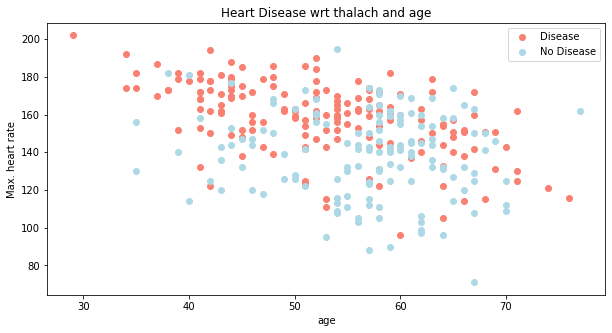

In [8]:
plt.figure(figsize=(10,5))

#scatter with positive examples
plt.scatter(df.age[df.target==1],
           df.thalach[df.target==1],
           c="salmon")

#Scatter with negetive examples
plt.scatter(df.age[df.target==0],
           df.thalach[df.target==0],
           c="lightblue")

plt.title("Heart Disease wrt thalach and age")
plt.xlabel("age")
plt.ylabel("Max. heart rate")
plt.legend(["Disease","No Disease"])

### Draw up correlational matrix

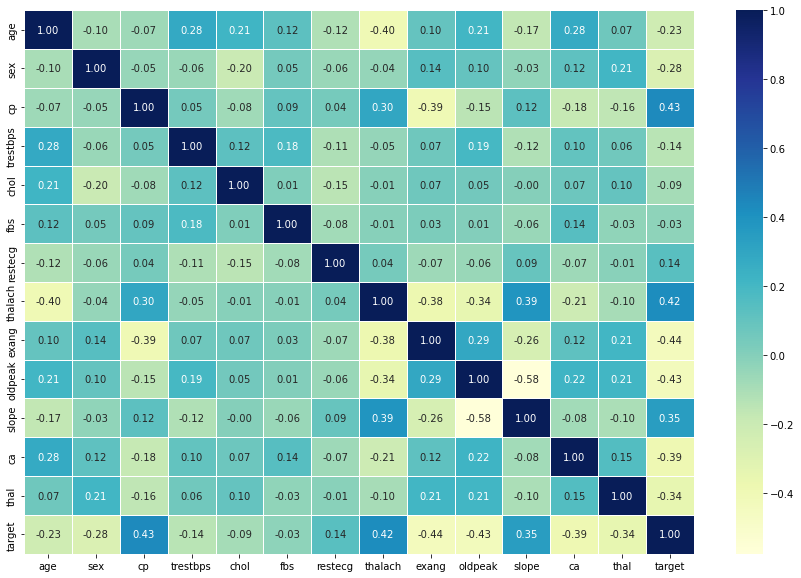

In [9]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt=".2f",
                cmap="YlGnBu");

In [10]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Getting data ready for Model creation

In [11]:
# Split the data into lable and features
x = df.drop("target",axis = 1)
y = df.target

In [12]:
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

In [13]:
x

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [14]:
# split the data into train and test split
np.random.seed(42)

# split into train and test set
x_train,x_test,y_train,y_test = train_test_split(x,
                                                y,
                                                test_size = 0.2)

In [15]:
x_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2
202,58,1,0,150,270,0,0,111,1,0.8,2,0,3
196,46,1,2,150,231,0,1,147,0,3.6,1,0,2
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2
176,60,1,0,117,230,1,1,160,1,1.4,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,50,1,2,140,233,0,1,163,0,0.6,1,1,3
71,51,1,2,94,227,0,1,154,1,0.0,2,1,3
106,69,1,3,160,234,1,0,131,0,0.1,1,1,2
270,46,1,0,120,249,0,0,144,0,0.8,2,0,3


In [16]:
y_train

132    1
202    0
196    0
75     1
176    0
      ..
188    0
71     1
106    1
270    0
102    1
Name: target, Length: 242, dtype: int64

## fitting the data into Modal

Applying three ML models
1. Logistic Regression
2. K-Nearest Neighbours
3. Ramdom Forest

In [17]:
# Put Models into a dictionary
models = {"Logistic Regression" : LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "svm": LinearSVC(),
         "Naive Bayes": GaussianNB()}

# Create a function to fit the models
def fit_and_score(models, x_train, x_test, y_train, y_test):
    np.random.seed(42)
    # Make a dictionary to keep modal scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(x_train, y_train)
        # Evaluate modal and append its scores to model_scores
        model_scores[name] = model.score(x_test,y_test)
    return model_scores

In [18]:
model_scores = fit_and_score(models = models,
                            x_train=x_train,x_test=x_test,y_train=y_train,y_test=y_test)
model_scores

/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8360655737704918,
 'svm': 0.819672131147541,
 'Naive Bayes': 0.8688524590163934}

In [19]:
# Tuning logistic regression

In [20]:
# Creating a hyperparameter grid for logistic regression
log_reg_grid = {"C": np.logspace(-4,4,20),
               "solver":["liblinear"]}

# Creating a hyperparameter grid for random forest classification
rf_grid = {"n_estimators": np.arange(10,1000,50),
          "max_depth": [None,3,5,10],
          "min_samples_split": np.arange(2,20,2),
          "min_samples_leaf": np.arange(1,20,2)}

# Creating a hyperparameter grid for GaussianNB
nb_grid = {"var_smoothing": np.logspace(0,-9, num=100)}

In [21]:
# Tuning the models
np.random.seed(42)

# 1. Logistic regression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                               param_distributions = log_reg_grid,
                               cv = 5,
                               n_iter = 20,
                               verbose = True)
# fit the model
rs_log_reg.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [22]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [23]:
rs_log_reg.score(x_test,y_test)

0.8852459016393442

In [24]:
#2. Randomforest
np.random.seed(42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                          param_distributions=rf_grid,
                          cv=5,
                          n_iter=20,
                          verbose = True)

# tune the model
rs_rf.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [25]:
rs_rf.best_params_

{'n_estimators': 210,
 'min_samples_split': 4,
 'min_samples_leaf': 19,
 'max_depth': 3}

In [26]:
rs_rf.score(x_test,y_test)

0.8688524590163934

In [27]:
#3. GaussianNB
rs_nb = RandomizedSearchCV(GaussianNB(),
                          param_distributions=nb_grid,
                          cv=5,
                          n_iter=20,
                          verbose=True)
#tune
rs_nb.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=20,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.5111917...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   verbose=True)

In [28]:
rs_nb.best_params_

{'var_smoothing': 1.873817422860383e-05}

In [29]:
rs_nb.score(x_test,y_test)

0.8688524590163934

### Using Grid Search

In [30]:
# Using the same grid of randomforest
gs_log_reg = GridSearchCV(LogisticRegression(),
                    param_grid=log_reg_grid,
                    cv=5,
                    verbose=True)

gs_log_reg.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [31]:
gs_log_reg.score(x_test,y_test)

0.8852459016393442

In [32]:
# Using the same grid of GaussianNB
gs_nb = GridSearchCV(GaussianNB(),
                    param_grid=nb_grid,
                    cv=5,
                    verbose=True)

gs_nb.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=True)

In [33]:
gs_nb.score(x_test,y_test)

0.8688524590163934

## Accuracy achieved 88.5%

### Trying Neural Networks

In [34]:
from sklearn.neural_network import MLPClassifier

In [35]:
NN = MLPClassifier()
NN.fit(x_train,y_train)

MLPClassifier()

In [36]:
NN.score(x_test,y_test)

0.8524590163934426

In [37]:
NN_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [38]:
gs_NN = GridSearchCV(MLPClassifier(),
                     param_grid=NN_grid, 
                     n_jobs=-1, 
                     cv=5,
                     verbose=True)
gs_NN.fit(x_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic 

/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic 

/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic 

/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic 

/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic 

/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic 

GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             verbose=True)

In [39]:
gs_NN.score(x_test,y_test)

0.8360655737704918

### Highest accuracy achieved was, in logistic regression i.e. 88.5%

# Evaluating our model

In [40]:
y_pred = gs_log_reg.predict(x_test)
print(y_pred)

[0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0]


In [41]:
np.array(y_test)

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])

/Users/aniketgaldhar/Desktop/heart-diesease-prediction/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


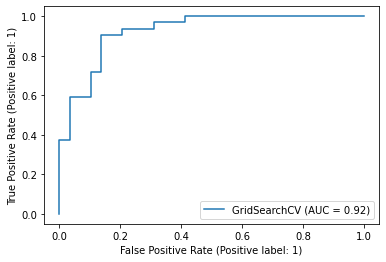

In [42]:
# Plot ROC curve
plot_roc_curve(gs_log_reg,x_test,y_test)

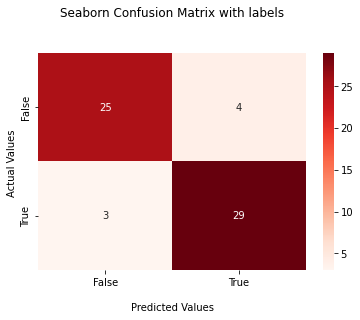

In [43]:
# confusion matrix
ax = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Reds')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [44]:
# Print classification report
class_report = classification_report(y_test,y_pred)

In [45]:
print(class_report)

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



## Feature Importance

In [46]:
gs_log_reg.best_params_

{'C': 0.23357214690901212, 'solver': 'liblinear'}

In [47]:
model = LogisticRegression(C = 0.23357214690901212, solver = 'liblinear')
model.fit(x_train,y_train)

LogisticRegression(C=0.23357214690901212, solver='liblinear')

In [48]:
model.coef_

array([[ 0.00369922, -0.90424086,  0.67472828, -0.0116134 , -0.00170364,
         0.04787689,  0.33490186,  0.02472938, -0.63120402, -0.57590915,
         0.47095118, -0.6516535 , -0.69984201]])

In [49]:
feature_dict = dict(zip(df.columns, list(model.coef_[0])))
feature_dict

{'age': 0.0036992187998289602,
 'sex': -0.9042408617254584,
 'cp': 0.6747282785211093,
 'trestbps': -0.011613403576031968,
 'chol': -0.0017036447029589036,
 'fbs': 0.04787688844705352,
 'restecg': 0.33490185589260435,
 'thalach': 0.02472938483022642,
 'exang': -0.6312040200034894,
 'oldpeak': -0.5759091523131389,
 'slope': 0.4709511814885769,
 'ca': -0.651653504206039,
 'thal': -0.6998420129807071}

<AxesSubplot:>

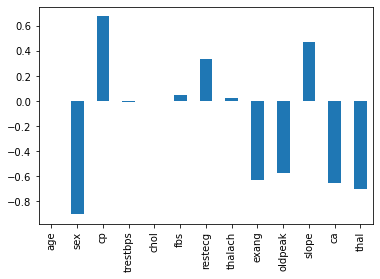

In [50]:
features = pd.DataFrame(feature_dict, index=[0])
features.T.plot.bar(legend = False)